# Multiple Regression (gradient descent)

In this notebook we will apply multivariate to estimate multiple regression weights via gradient descent. 

* To implement I will add a constant column of 1's to a graphlab SFrame to account for the intercept
* Convert an SFrame into a Numpy array
* Write a predict_output() function using Numpy
* Write a numpy function to compute the derivative of the regression weights with respect to a single feature
* Write gradient descent function to compute the regression weights given an initial weight vector, step size and tolerance.
* Use the gradient descent function to estimate regression weights for multiple features

# Import library

In [2]:
%matplotlib inline
import time
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from math import sqrt

# Load in house sales data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

In [3]:
data = pd.read_csv("kc_house_data.csv")
colname_lst = list(data.columns.values)
coltype_lst =  [str, str, float, float, float, float, int, str, int, int, int, int, int, int, int, int, str, float, float, float, float]
col_type_dict = dict(zip(colname_lst, coltype_lst))

# Split data into training data and test data 

From the entire dataset above, we spit data into training and test set using numpy.

In [4]:
idx = np.random.rand(len(data)) < 0.8
train = data[idx]
test = data[~idx]

In [5]:
#inspect first five elements in the training set
train.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900,3,1.0,1180,5650,1,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
2,5631500400,20150225T000000,180000,2,1.0,770,10000,1,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000,4,3.0,1960,5000,1,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000,3,2.0,1680,8080,1,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
5,7237550310,20140512T000000,1225000,4,4.5,5420,101930,1,0,0,...,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930


In [6]:
#inspect first five elements in the test set
test.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1,6414100192,20141209T000000,538000,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
6,1321400060,20140627T000000,257500,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
16,1875500060,20140731T000000,395000,3,2.00,1890,14040,2.0,0,0,...,7,1890,0,1994,0,98019,47.7277,-121.962,1890,14018
21,2524049179,20140826T000000,2000000,3,2.75,3050,44867,1.0,0,4,...,9,2330,720,1968,0,98040,47.5316,-122.233,4110,20336
25,1202000200,20141103T000000,233000,3,2.00,1710,4697,1.5,0,0,...,6,1710,0,1941,0,98002,47.3048,-122.218,1030,4705


# Data visualisation 

In ths section, we will look at some of the data visually in order to get the gist of data

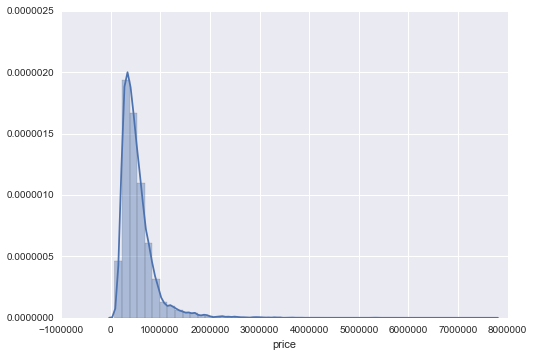

In [7]:
# let inspect the distribution of 'price'
sns.distplot(train["price"])

The following will plot longitude&latitude of houses in this data set to see if they are all located in  Seattle, WA and aslo gives me an idea wheresabout Seattle is located.

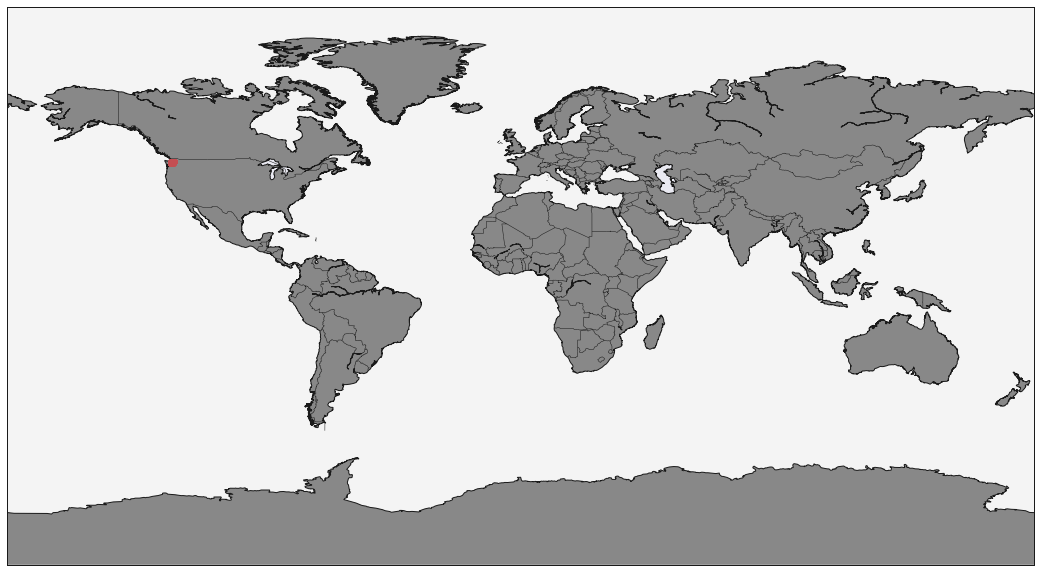

In [8]:
# Create a figure of size (i.e. pretty big)
fig = plt.figure(figsize=(20,10))

# Create a map, using the Gall–Peters projection, 
map = Basemap(projection='gall', 
              # with low resolution,
              resolution = 'l', 
              # And threshold 100000
              area_thresh = 100000.0,
              # Centered at 0,0 (i.e null island)
              lat_0=0, lon_0=0)

# Draw the coastlines on the map
map.drawcoastlines()

# Draw country borders on the map
map.drawcountries()

# Fill the land with grey
map.fillcontinents(color = '#888888')

# Draw the map boundaries
map.drawmapboundary(fill_color='#f4f4f4')

# Define our longitude and latitude points
# We have to use .values because of a wierd bug when passing pandas data
# to basemap.
x,y = map(train['long'].values, train['lat'].values)

# Plot them using round markers of size 6
map.plot(x, y, 'ro', markersize=6)

# Show the map
plt.show()

# Convert to Numpy Array

Now we will write a function that will accept a dataframe, a list of feature names (e.g. ['sqft_living', 'bedrooms']) and an target feature e.g. ('price') and will return two things:
* A numpy matrix whose columns are the desired features plus a constant column (this is how we create an 'intercept')
* A numpy array containing the values of the output

In [9]:
def get_numpy_data(df, features, output):
    df['constant'] = 1 # this is how you add a constant column to an SFrame
    # add the column 'constant' to the front of the features list so that we can extract it along with the others:
    features = ['constant'] + features # this is how you combine two lists
    # select the columns of data_SFrame given by the features list into the SFrame features_sframe (now including constant):
    features_df = df[features]
    # the following line will convert the features_SFrame into a numpy matrix:
    feature_matrix = features_df.as_matrix()
    # assign the column of data_sframe associated with the output to the SArray output_sarray
    output_serie = df[output]
    # the following will convert the SArray into a numpy array by first converting it to a list
    output_array = output_serie.as_matrix()
    return(feature_matrix, output_array)

For testing let's use the 'sqft_living' feature and a constant as our features and price as our output:

In [10]:
(example_features, example_output) = get_numpy_data(train, ['sqft_living'], 'price')
print example_features[0,:] # this accesses the first row of the data the ':' indicates 'all columns'
print example_output[0] # and the corresponding output

[   1 1180]
221900.0


# Predicting output given regression weights

Suppose we had the weights [1.0, 1.0] and the features [1.0, 1180.0] and we wanted to compute the predicted output 1.0\*1.0 + 1.0\*1180.0 = 1181.0 this is the dot product between these two arrays. If they're numpy arrays we can use np.dot() to compute this:

In [11]:
my_weights = np.array([1., 1.]) # the example weights
my_features = example_features[0,] # we'll use the first data point
predicted_value = np.dot(my_features, my_weights)
print predicted_value

1181.0


np.dot() also works when dealing with a matrix and a vector. The predictions from all the observations is the dot product between the features *matrix* and the weights *vector*. The following predict_output function is to compute the predictions for an entire matrix of features given the matrix and the weights:

In [12]:
def predict_output(feature_matrix, weights):
    # assume feature_matrix is a numpy matrix containing the features as columns and weights is a corresponding numpy array
    # create the predictions vector by using np.dot()
    predictions = np.dot(feature_matrix, weights)
    return(predictions)

The following cell is used to test the code:

In [13]:
test_predictions = predict_output(example_features, my_weights)
print test_predictions[0] # should be 1181.0
print test_predictions[1] # should be 2571.0

1181.0
771.0


# Computing the Derivative

We are now going to compute the derivative of the regression cost function. The cost function is the sum over the data points of the squared difference between an observed output and a predicted output.

Since the derivative of a sum is the sum of the derivatives we can compute the derivative for a single data point and then sum over data points. We can write the squared difference between the observed output and predicted output for a single point as follows:

$$(w_0 \cdot h_0(x_i)+(w_1 \cdot h_1(x_i) + \dots+w_k \cdot h_k(w_k)-y_i)^2 = w[0]\cdot[CONSTANT] + w[1]\cdot[feature_1] +\dots +  w[k]\cdot[feature_k] - output)^2 $$

Where we have k features and a constant. So the derivative **with respect to weight w[i]** by the chain rule is:

$$2 \cdot (w[0]\cdot [CONSTANT] + w[1]\cdot [feature_1] + \dots + w[i] \cdot [feature_i] + \dots +  w[k]\cdot [feature_k] - output)\cdot [feature_i]$$

The term inside the paranethesis is just the error (difference between prediction and output). So we can re-write this as:

$$2\cdot error[feature_i]$$

That is, the derivative for the weight for feature i is the sum (over data points) of 2 times the product of the error and the feature itself. 
In the case of the constant then this is just twice the sum of the errors as thr feature is constant and represented by array of 1s.

Note: twice the sum of the product of two vectors is just twice the dot product of the two vectors. Therefore the derivative for the weight for feature_i is just two times the dot product between the values of feature_i and the current errors. 

The following derivative function computes the derivative of the weight given the value of the feature (over all data points) and the errors (over all data points).

In [14]:
def feature_derivative(errors, feature):
    # Assume that errors and feature are both numpy arrays of the same length (number of data points)
    # compute twice the dot product of these vectors as 'derivative' and return the value
    derivative = 2*np.dot(errors, feature)
    
    return(derivative)

To test your feature derivartive run the following:

In [15]:
(example_features, example_output) = get_numpy_data(train, ['sqft_living'], 'price') 
my_weights = np.array([0., 0.]) # this makes all the predictions 0
test_predictions = predict_output(example_features, my_weights) 
errors = test_predictions - example_output # prediction errors in this case is just the -example_output
feature = example_features[:,0] # let's compute the derivative with respect to 'constant', the ":" indicates "all rows"
derivative = feature_derivative(errors, feature)
print derivative
print -np.sum(example_output)*2 # should be the same as derivative

-18686397554.0
-18686397554.0


# Gradient Descent

Now we will write a function that performs a gradient descent. The basic premise is simple. Given a starting point we update the current weights by moving in the negative gradient direction. Note that the gradient is the direction of *increase* and therefore the negative gradient is the direction of *decrease* and we're trying to *minimise* a cost/error function. 

The amount by which we move in the negative gradient *direction*  is called the 'step size'. We stop when we are 'sufficiently close' to the optimum. We define this by requiring that the magnitude of the gradient vector to be smaller than a fixed 'tolerance'.

The following gradient descent function uses the derivative function above. For each step in the gradient descent we update the weight for each feature befofe computing our stopping criteria

In [66]:
def regression_gradient_descent(feature_matrix, output, initial_weights, step_size, tolerance):
    converged = False 
    weights = np.array(initial_weights) # make sure it's a numpy array
    while not converged:
        # compute the predictions based on feature_matrix and weights using your predict_output() function
        predictions = predict_output(feature_matrix, weights)
        # compute the errors as predictions - output
        error = predictions - output
        gradient_sum_squares = 0 # initialize the gradient sum of squares
        # while we haven't reached the tolerance yet, update each feature's weight
        for i in range(len(weights)): # loop over each weight
            # Recall that feature_matrix[:, i] is the feature column associated with weights[i]
            feature = feature_matrix[:, i]
            # compute the derivative for weight[i]:
            derivative = feature_derivative(error,feature)
            # add the squared value of the derivative to the gradient sum of squares (for assessing convergence)
            gradient_sum_squares += derivative ** 2
            # subtract the step size times the derivative from the current weight
            weights[i] = weights[i] - np.dot(step_size,derivative)
        # compute the square-root of the gradient sum of squares to get the gradient matnigude/length of a vector:
        gradient_magnitude = sqrt(gradient_sum_squares)
        if gradient_magnitude < tolerance:
            converged = True
        #print gradient_magnitude 
        #time.sleep(1)
    return(weights)

A few things to note before running the gradient descent. Since the gradient is a sum over all the data points and involves a product of an error and a feature the gradient itself will be very large since the features are large (squarefeet) and the output is large (prices). So while we expect "tolerance" to be small, small is only relative to the size of the features. 

For similar reasons the step size will be much smaller than we might expect but this is because the gradient has such large values.

# Running the Gradient Descent as Simple Regression

First let's split the data into training and test data.

Although the gradient descent is designed for multiple regression since the constant is now a feature we can use the gradient descent function to estimat the parameters in the simple regression on squarefeet. The folowing cell sets up the feature_matrix, output, initial weights and step size for the first model:

In [23]:
# let's test out the gradient descent
simple_features = ['sqft_living']
my_output = 'price'
(simple_feature_matrix, output) = get_numpy_data(train, simple_features, my_output)
initial_weights = np.array([1., 1.])
step_size = 7e-12
tolerance = 2.5e8

Next let's run our gradient descent with the above parameters.

In [24]:
model_weights = regression_gradient_descent(simple_feature_matrix, output, initial_weights, step_size, tolerance)
model_weights

array([-1230.97379315,   263.52246994])

Use our newly estimated weights and your predict_output() function to compute the predictions on all the TEST data using test_simple_feature_matrix and your weights from above.

In [25]:
(test_simple_feature_matrix, test_output) = get_numpy_data(test, simple_features, my_output)
simple_weights = regression_gradient_descent(test_simple_feature_matrix, test_output, initial_weights, step_size, tolerance)
predictions = predict_output(test_simple_feature_matrix, simple_weights)

Now that we have the predictions on test data, let's compute the RSS on the test data set. 

In [26]:
def compute_rss(test_output, predictions):
    residuals = test_output - predictions 
    rss = (residuals * residuals).sum()
    return rss
compute_rss(test_output, predictions)

292435195058503.87

# Running a multiple regression

Now we will use more than one actual feature. Use the following code to produce the weights for a second model with the following parameters:

In [67]:
model_features = ['sqft_living', 'sqft_living15'] # sqft_living15 is the average squarefeet for the nearest 15 neighbors. 
my_output = 'price'
(feature_matrix, output) = get_numpy_data(train, model_features, my_output)
initial_weights = np.array([1., 1., 1.])
step_size = 4e-12
tolerance = 3e9

Now, we will use the above parameters to estimate the model weights.

In [68]:
model_weights = regression_gradient_descent(feature_matrix, output, initial_weights, step_size, tolerance)
model_weights 

array([   0.66082694,  240.70210762,   25.0654162 ])

Use our newly estimated weights and the predict_output function to compute the predictions on the TEST data. 

In [69]:
(test_simple_feature_matrix, test_output) = get_numpy_data(test, model_features, my_output)
simple_weights = regression_gradient_descent(test_simple_feature_matrix, test_output, initial_weights, step_size, tolerance)
predictions = predict_output(test_simple_feature_matrix, simple_weights)

Now that we have the predictions on test data, let's compute the RSS on the test data set. 

In [70]:
def compute_rss(test_output, predictions):
    residuals = test_output - predictions 
    rss = (residuals * residuals).sum()
    return rss
compute_rss(test_output, predictions)

291333833505609.0

*last edit 25/10/2016*